In [1]:
import pandas as pd
import numpy as np
from sketching_algorithms import *
import matplotlib.pyplot as plt
import time
from mlxtend.frequent_patterns import apriori,association_rules,fpgrowth
import warnings
import sys
import scipy.stats as stats
import random 
import json
import statistics as stats
import heapq
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

# step 1 , load and clean data

In [2]:
df = pd.read_csv('Online Retail.csv')
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [3]:
print("column names : ", df.columns)

column names :  Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [4]:
# i will check if there is any null value in any columns
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
# we consider null customer id as not completed or rejected invoices so we will remove them

In [6]:
df = df[df['CustomerID'].notna() & (df['CustomerID'] != '')]

In [7]:
# now remove unecessery cols
df = df.drop(["InvoiceDate","UnitPrice","CustomerID","Country"], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    406829 non-null  object
 1   StockCode    406829 non-null  object
 2   Description  406829 non-null  object
 3   Quantity     406829 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 15.5+ MB


In [9]:
# df.describe() , useless in this case

In [10]:
# here i will remove items with 0 or negative quantity
negative_quantity = (df['Quantity'] < 0).sum()
zero_quantity = (df['Quantity'] == 0).sum()
print(f"number of negative quantity values {negative_quantity}, number of zero quantity {zero_quantity}")

number of negative quantity values 8905, number of zero quantity 0


In [11]:
# only keep rows with above zero quantity
# drop description , because some stock numbers are empty
# there is no way we can interpolate or ... them precisely , maybe they are not product but i dont want to lose data , so i will keep
# using them , later i will query data set to get description if available

df = df[df['Quantity'] >= 0]
lookup_df = df.drop(["InvoiceNo","Quantity"], axis=1).drop_duplicates(subset=['StockCode']) # i will use this for finding desc base on stockno
df = df.drop(["Description","Quantity"], axis=1)
print(df.head()) # here step 1 is completed and we have a cleaned data

  InvoiceNo StockCode
0    536365    85123A
1    536365     71053
2    536365    84406B
3    536365    84029G
4    536365    84029E


In [12]:
def get_descrption(stock_code):
    # filter rows where first column matches stock_code
    rows = lookup_df[lookup_df.iloc[:, 0] == stock_code]
    
    if rows.empty:
        return -1  # stock_code not found
    # description can be nan for one row and non nan for other row
    # iterate over descriptions and return first non nan
    for descr in rows.iloc[:, 1]:
        if pd.notna(descr):
            return descr
    # If all are nan
    return "no description"

    
print(get_descrption("84534B")) # 84534B is an example of an stock_code wiht nan and non nan data

FAIRY CAKE NOTEBOOK A5 SIZE


In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   InvoiceNo  397924 non-null  object
 1   StockCode  397924 non-null  object
dtypes: object(2)
memory usage: 9.1+ MB
None


# step 2 , creating binary matrix

In [14]:
# here i want to make an new dataframe , rows are invoice no , cols are existance of an item
# binary_df = pd.get_dummies(df['Description'], dtype=int).groupby(df['InvoiceNo']).sum()

'''
bottom part will do one hot encoding ()
pd.get_dummies(df['Description'], dtype=int)
.groupby(df['InvoiceNo']).sum()
it will sum dupplicate invoiceno rows , it will casue the exact thing we want

i ran out of memory :| ...
'''

"\nbottom part will do one hot encoding ()\npd.get_dummies(df['Description'], dtype=int)\n.groupby(df['InvoiceNo']).sum()\nit will sum dupplicate invoiceno rows , it will casue the exact thing we want\n\ni ran out of memory :| ...\n"

In [15]:
# trying to Sparse[int] , because there will loots of zeros , there are other ways too but this will do the jobS
# binary_df = pd.get_dummies(df['StockCode'], dtype='Sparse[int]').groupby(df['InvoiceNo']).sum()
# this takes for ever!

In [16]:
df['StockCode'] = df['StockCode'].astype('category')
# as chatgpt says , cross table is exactly what we want in an optimal way :
# Takes two or more categorical inputs (usually Series or arrays).
# Counts how many times each unique pair of values occurs.
# Returns a DataFrame with one factor as rows, the other as columns, and counts as values.
# example :
# data = {
#     'Gender': ['Male', 'Female', 'Female', 'Male', 'Female'],
#     'Preference': ['Football', 'Football', 'Tennis', 'Tennis', 'Football']
# }
# out put look like below :
# | Preference | Football | Tennis |
# | ---------- | -------- | ------ |
# | Gender     |          |        |
# | Female     | 2        | 1      |
# | Male       | 1        | 1      |

binary_df = pd.crosstab(df['InvoiceNo'], df['StockCode'])
binary_df = binary_df.astype('Sparse[int]')
binary_df = (binary_df > 0).astype('Sparse[int]')


In [17]:
binary_df.info()
binary_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 18536 entries, 536365 to 581587
Columns: 3665 entries, 10002 to POST
dtypes: Sparse[int32, 0](3665)
memory usage: 3.1+ MB


StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
new_cols = [get_descrption(st) for st in binary_df.columns.values]

In [19]:
data = binary_df.to_numpy()
data_length = data.shape[0]
num_features = data.shape[1]
print(f"data_length: {data_length}, num features: {num_features}")

data_length: 18536, num features: 3665


# step 3 and so on

In [20]:
# for pandas not truncating output

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.width', 10000)

In [69]:
# these are all hyperparameters can be set for this app!
hp = {
    "flow_size" : 500, # number of rows at each flow is being loaded
    "sketch_size" : 100, # numbre of rows of sketch 
    "sketch_binary_thresh": 0.5 , # >thresh is 1 else 0 
    "sketch_binary_thresh_grow": 0.01 , # >thresh is 1 else 0 
    # setting this 0 (positive 1 , negative 0) will make the sketches so dense and hard to compute assoc rules (apiriori ran out of mem !)
    # i will set higher for faster compute
    "min_sup": 0.05,
    "min_conf" : 0.05,
    "gaussian_random_project_error":0.5,
    "anomaly_top_singular":50, # "sketch_size"/2
    # "anomaly_proj_dist_thres":50,
    # "anomaly_lev_thres":50,
    "anomaly_minheap_size" : 5000,
    "anomaly_top_percent":0.95,
    "ipca_ncomponent":500#int(num_features/2)

}

In [22]:
# # anomalies
# def random_unique_list(m, n, z):
#     if m > n:
#         m, n = n, m
#     if z > (n - m + 1):
#         raise ValueError("z cannot be larger than the number of unique values in the range.")
#     return random.sample(range(m, n + 1), z)

# gt_anomalies = random_unique_list(hp["flow_size"]+5,data_length,1000) # i dont want anomaly in first flow
# print(sorted(gt_anomalies))

In [23]:
with open('anomalies.json', 'r') as f:
    anomalies_gt = json.load(f)

print(len(anomalies_gt))

1000


<h1>#########################################</h1>
this part of code calculate sketches using frequent directions and then calc apiriori and fp growth on them<br>
we also monitor frob norm and total variance , we cannot reconstruct main matrix from sketch so reconstruction error is not here

In [24]:
## ground truth freq item set
sys.stdout = open(r".\outputs\frequent item set ground truth.txt","w")
gt_min_sup = 0.015
gt_min_conf = 0.015
print("apriori")
binary_df.columns=new_cols
frequent_itemsets_apiriori_gt = apriori(binary_df, min_support=gt_min_sup, use_colnames=True)
if (not frequent_itemsets_apiriori_gt.empty):
    print(f"frequent itemsets with minsup {gt_min_sup}\n{frequent_itemsets_apiriori_gt}\n", flush=True)
    rules_apiriori_gt = association_rules(frequent_itemsets_apiriori_gt, metric="confidence", min_threshold=gt_min_conf)
    print(f"association rules with minconf {gt_min_conf}\n{rules_apiriori_gt[['antecedents', 'consequents', 'support', 'confidence', 'lift']]}\n", flush=True)
else : 
    print(f"frequent itemsets with minsup {gt_min_sup} had no result", flush=True)

print("fp-growth")
frequent_itemsets_fp_gt = fpgrowth(binary_df, min_support=gt_min_sup, use_colnames=True)
if (not frequent_itemsets_fp_gt.empty):
    print(f"frequent itemsets with minsup {gt_min_sup}\n{frequent_itemsets_fp_gt}\n", flush=True)
    rules_fp_gt = association_rules(frequent_itemsets_fp_gt, metric="confidence", min_threshold=gt_min_conf)
    print(f"association rules with minconf {gt_min_conf}\n{rules_fp_gt[['antecedents', 'consequents', 'support', 'confidence', 'lift']]}\n", flush=True)
else : 
    print(f"frequent itemsets with minsup {gt_min_sup} had no result", flush=True)

number_of_apirioti_gt_itemsets = frequent_itemsets_apiriori_gt.shape[0]
number_of_apiriori_rules_gt = rules_apiriori_gt.shape[0]
number_of_fp_gt_itemsets = frequent_itemsets_fp_gt.shape[0]
number_of_fp_rules_gt = rules_fp_gt.shape[0]


In [25]:
sys.stdout = open(r".\outputs\output_freqdir.txt","w")
frob_norms = []
tot_variances = []
apriori_times = []
fpgrowth_times = []
freqdir_times = []

true_positive_apiriori = []
false_positive_apiriori = [] # reported as itemset but they are not
true_positive_fp = []
false_positive_fp = [] # reported as itemset but they are not
true_positive_apiriori_assoc = []
false_positive_apiriori_assoc = [] # reported as assoc rule but they are not
true_positive_fp_assoc = []
false_positive_fp_assoc = [] # reported as assoc rule but they are not

density_over_time = []

for epoch,flow_start_idx in enumerate(range(0,data_length,hp["flow_size"])):
    print(f"------------ epoch {epoch+1} / {int(data_length/hp["flow_size"])+1} ------------", flush=True)

    hp["sketch_binary_thresh"] += hp["sketch_binary_thresh_grow"]

    flow_end_idx = flow_start_idx+hp["flow_size"]
    if(flow_end_idx>data_length): flow_end_idx=data_length
    print(f"loading rows {flow_start_idx} to {flow_end_idx}", flush=True)
    flow = data[flow_start_idx:flow_end_idx]
    if (epoch==0):
        start_time = time.time()
        frob_norms.append(frobenius_norm(flow))
        tot_variances.append(total_variance(flow))
        flow_df = pd.DataFrame(flow, columns=new_cols,dtype="Sparse[int]")
        density_over_time.append(flow_df.values.sum() / (flow_df.shape[0]*flow_df.shape[1]))
        print("first flow density: ", density_over_time[-1], flush=True)
        sketch = np.zeros((hp["sketch_size"], num_features))
        end_time = time.time()
        print(f"processing first flow took {end_time - start_time:.4f} seconds", flush=True)

    # now we do freq dir sketch
    start_time = time.time()
    sketch = frequent_directions(hp["sketch_size"],flow,sketch)
    end_time = time.time()
    print(f"frequent directions took {end_time - start_time:.4f} seconds", flush=True)
    freqdir_times.append(int(end_time - start_time))
    # calc frob norm
    frob_norms.append(frobenius_norm(sketch))
    tot_variances.append(total_variance(sketch))
    # print(np.median(sketch))
    ################################################################################
    print(f"starting association rule learning", flush=True)
    start_time = time.time()
    sketch_bin = (sketch > hp["sketch_binary_thresh"]).astype(int)
    sketch_df = pd.DataFrame(sketch_bin, columns=new_cols,dtype="Sparse[int]")
    # print("Sketch non-zero count:", sketch_df.values.sum(), flush=True)
    density_over_time.append(sketch_df.values.sum() / (sketch_df.shape[0]*sketch_df.shape[1]))
    print("tresh ",hp["sketch_binary_thresh"]," Sketch density: ", density_over_time[-1], flush=True)
    end_time = time.time()
    print(f"sketch is ready for association rule learning ( took {end_time - start_time:.4f} seconds )", flush=True)
    # freq pattern
    start_time = time.time()
    print("apiriori algorithm started", flush=True)
    frequent_itemsets = apriori(sketch_df, min_support=hp["min_sup"], use_colnames=True)
    # calc tp and fp ######
    # used frozensets so we can do intersectioon and ...
    gt_sets = set(frozenset(x) for x in frequent_itemsets_apiriori_gt['itemsets'])
    pred_sets = set(frozenset(x) for x in frequent_itemsets['itemsets'])
    true_positive_apiriori.append(len(pred_sets & gt_sets))  # intersection
    false_positive_apiriori.append(len(pred_sets - gt_sets))  # items in pred but not in gt
    ###############
    if (not frequent_itemsets.empty):
        print(f"[apiriori] frequent itemsets with minsup {hp["min_sup"]}\n{frequent_itemsets}\n", flush=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=hp["min_conf"])
        print(f"[apiriori] association rules with minconf {hp["min_conf"]}\n{rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]}\n", flush=True)
        # calc tp and fp for assoc rules
        # convert to tupple so order of ant and con matter
        gt_rules = set((frozenset(row['antecedents']), frozenset(row['consequents'])) 
                    for _, row in rules_apiriori_gt.iterrows())
        pred_rules = set((frozenset(row['antecedents']), frozenset(row['consequents'])) 
                        for _, row in rules.iterrows())
        true_positive_apiriori_assoc.append(len(pred_rules & gt_rules))
        false_positive_apiriori_assoc.append(len(pred_rules - gt_rules))
        ########
    else :
        print(f"[apiriori] frequent itemsets with minsup {hp["min_sup"]} had no result", flush=True)
    end_time = time.time()
    print(f"apiriori took {end_time - start_time:.4f} seconds", flush=True)
    apriori_times.append(int(end_time - start_time))
    
    print("fpgrowth algorithm started", flush=True)
    start_time = time.time()
    frequent_itemsets = fpgrowth(sketch_df, min_support=hp["min_sup"], use_colnames=True)

    # calc tp and fp
    # used frozensets so we can do intersectioon and ...
    gt_sets = set(frozenset(x) for x in frequent_itemsets_fp_gt['itemsets'])
    pred_sets = set(frozenset(x) for x in frequent_itemsets['itemsets'])
    true_positive_fp.append(len(pred_sets & gt_sets))  # intersection
    false_positive_fp.append(len(pred_sets - gt_sets))  # items in pred but not in gt

    if (not frequent_itemsets.empty):
        print(f"[fpgrowth] frequent itemsets with minsup {hp["min_sup"]}\n{frequent_itemsets}\n", flush=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=hp["min_conf"])
        print(f"[fpgrowth] association rules with minconf {hp["min_conf"]}\n{rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]}\n", flush=True)
        # calc tp and fp for assoc rules
        # convert to tupple so order of ant and con matter
        gt_rules = set((frozenset(row['antecedents']), frozenset(row['consequents'])) 
                    for _, row in rules_fp_gt.iterrows())
        pred_rules = set((frozenset(row['antecedents']), frozenset(row['consequents'])) 
                        for _, row in rules.iterrows())
        true_positive_fp_assoc.append(len(pred_rules & gt_rules))
        false_positive_fp_assoc.append(len(pred_rules - gt_rules))
        ########
    else :
        print(f"[fpgrowth] frequent itemsets with minsup {hp["min_sup"]} had no result", flush=True)
    end_time = time.time()
    print(f"fpgrowth took {end_time - start_time:.4f} seconds", flush=True)
    fpgrowth_times.append(int(end_time - start_time))
        

In [26]:
# sys.stdout.close()

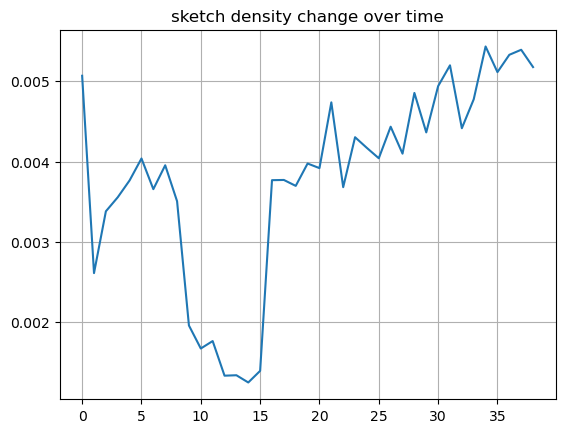

In [27]:
#print("note that first norm is for the first flow")
plt.title("sketch density change over time")
plt.plot(density_over_time)
plt.grid(True)
plt.show()

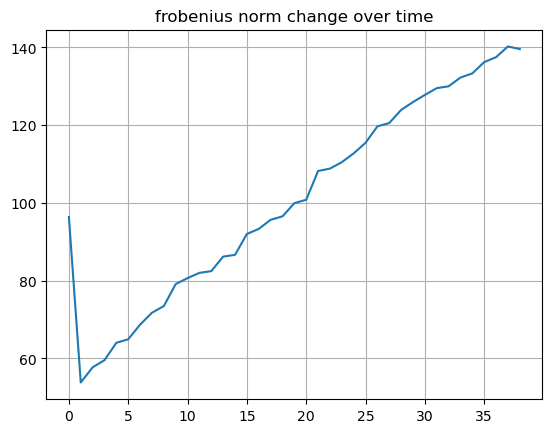

In [28]:
#print("note that first norm is for the first flow")
plt.title("frobenius norm change over time")
plt.plot(frob_norms)
plt.grid(True)
plt.show()

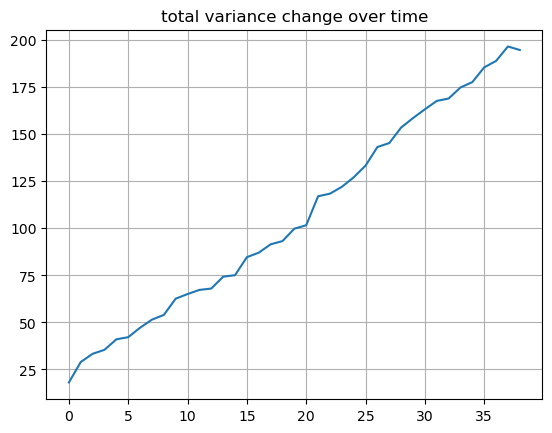

In [29]:
#print("note that first is for the first flow")
plt.title("total variance change over time")
plt.plot(tot_variances)
plt.grid(True)
plt.show()

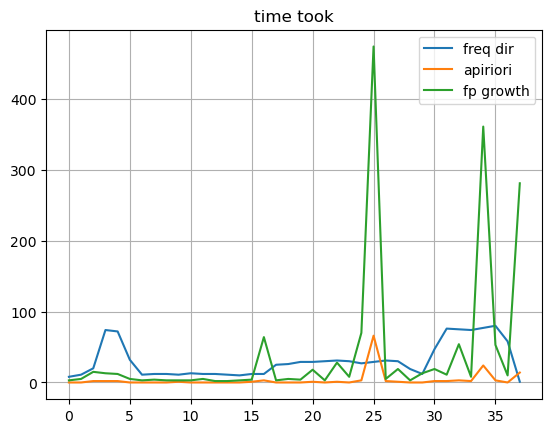

In [30]:
plt.title("time took")
plt.plot(freqdir_times,label="freq dir")
plt.plot(apriori_times,label="apiriori")
plt.plot(fpgrowth_times,label="fp growth")
plt.legend()
plt.grid(True)
plt.show()

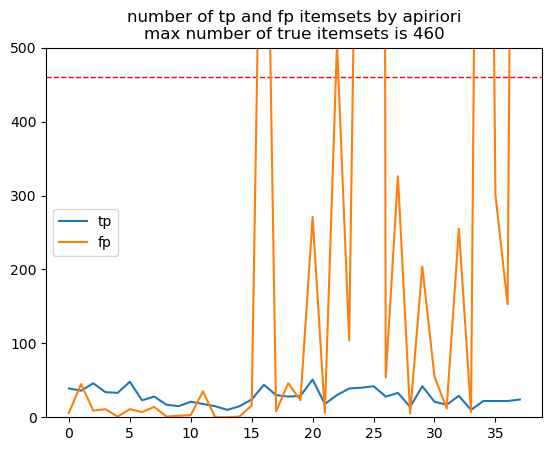

In [42]:
plt.title(f"number of tp and fp itemsets by apiriori\nmax number of true itemsets is {number_of_apirioti_gt_itemsets}")
plt.axhline(y=number_of_apirioti_gt_itemsets, color='red', linestyle='--', linewidth=1)
plt.plot(true_positive_apiriori,label="tp")
plt.plot(false_positive_apiriori,label="fp")
plt.ylim(0,500) 
plt.legend()
plt.show()

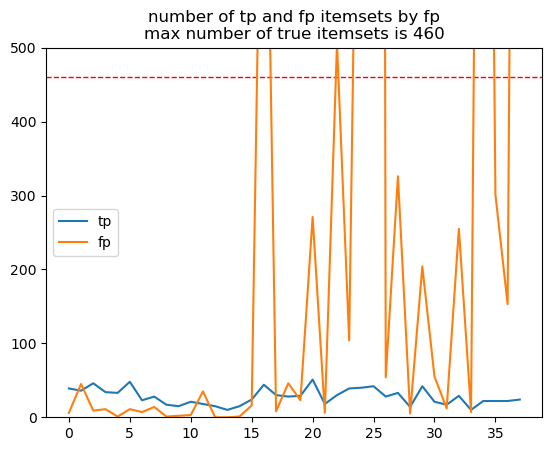

In [41]:
plt.title(f"number of tp and fp itemsets by fp\nmax number of true itemsets is {number_of_fp_gt_itemsets}")
plt.axhline(y=number_of_fp_gt_itemsets, color='red', linestyle='--', linewidth=1)
plt.plot(true_positive_fp,label="tp")
plt.plot(false_positive_fp,label="fp")
plt.ylim(0,500) 
plt.legend()
plt.show()

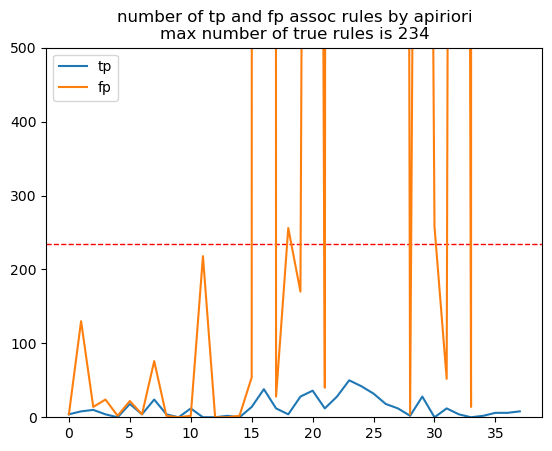

In [44]:
plt.title(f"number of tp and fp assoc rules by apiriori\nmax number of true rules is {number_of_apiriori_rules_gt}")
plt.axhline(y=number_of_apiriori_rules_gt, color='red', linestyle='--', linewidth=1)

plt.plot(true_positive_apiriori_assoc,label="tp")
plt.plot(false_positive_apiriori_assoc,label="fp")
plt.ylim(0,500) 

plt.legend()
plt.show()

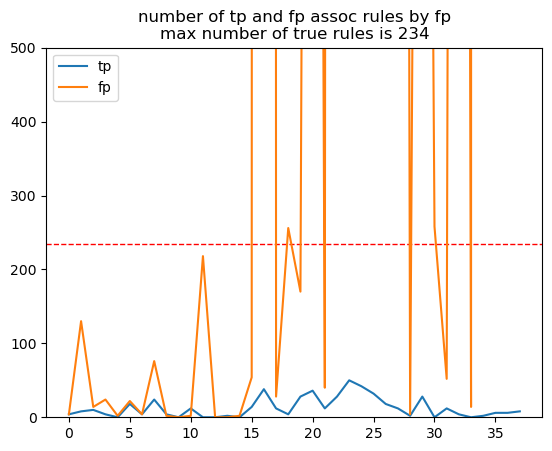

In [43]:
plt.title(f"number of tp and fp assoc rules by fp\nmax number of true rules is {number_of_fp_rules_gt}")
plt.axhline(y=number_of_fp_rules_gt, color='red', linestyle='--', linewidth=1)

plt.plot(true_positive_fp_assoc,label="tp")
plt.plot(false_positive_fp_assoc,label="fp")
plt.ylim(0,500) 
plt.legend()
plt.show()

<h1>#########################################</h1>
anomaly detection only frequent directions :

In [45]:
###########################
####injecting anomalies####
###########################

random_rows = np.random.randint(0, 2, size=(len(anomalies_gt), data.shape[1]))
# Calculate density
data[anomalies_gt] = random_rows

In [46]:
# check if proj dist and leverage are in normal distribiution
sys.stdout = open(r".\outputs\anomaly_freq.txt","w")
proj_dist_sample=[]
leverage_sample=[]

for epoch,flow_start_idx in enumerate(range(0,data_length,hp["flow_size"])):
    print(f"------------ epoch {epoch+1} / {int(data_length/hp["flow_size"])+1} ------------", flush=True)
    flow_end_idx = flow_start_idx+hp["flow_size"]
    if(flow_end_idx>data_length): flow_end_idx=data_length
    print(f"loading rows {flow_start_idx} to {flow_end_idx}", flush=True)
    flow = data[flow_start_idx:flow_end_idx]
    if (epoch==0):
        sketch = np.zeros((hp["sketch_size"], num_features))

    # anomaly detectoin
    if(epoch!=0):
        leverage, proj_dist = compute_anomaly_scores(data=flow,sketch=sketch,k=hp["anomaly_top_singular"])
        proj_dist_sample=(np.array(proj_dist))
        leverage_sample=(np.array(leverage))
        break


    # now we do freq dir sketch
    sketch = frequent_directions(hp["sketch_size"],flow,sketch)


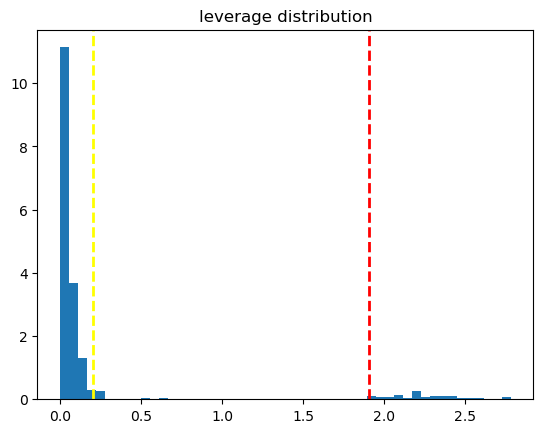

In [47]:
# as chat gpt said :
# density=False → y-axis shows counts (number of samples per bin).
# density=True → y-axis shows probability density (so you can compare to a theoretical PDF, like a normal distribution curve).
# no need for normalization becautse i just want to see the shape of its distribution

plt.hist(leverage_sample, bins=50, density=True)
plt.axvline(x=np.mean(leverage_sample), color='yellow', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(leverage_sample)+3*stats.stdev(leverage_sample), color='red', linestyle='--', linewidth=2)
plt.title("leverage distribution")
plt.show()

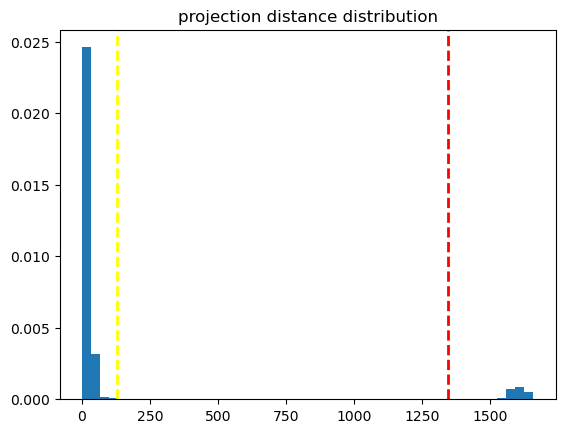

In [48]:
import matplotlib.pyplot as plt

plt.hist(proj_dist_sample, bins=50, density=True)
plt.axvline(x=np.mean(proj_dist_sample), color='yellow', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(proj_dist_sample)+3*stats.stdev(proj_dist_sample), color='red', linestyle='--', linewidth=2)
plt.title("projection distance distribution")
plt.show()


as paper said : for anomaly detection, the candidate anomalies are ones where leverage or dist_proj is large<br>
for this we always keep top 5000 anomalies with their scores and report top 95 of them as anomaly<br>
i store top 5000 inside a mean heap for better performance and report top 95% at each epoch<br>
if proj dists was normal distributed we could do mean+std is anomaly<br>


# anomaly method 1

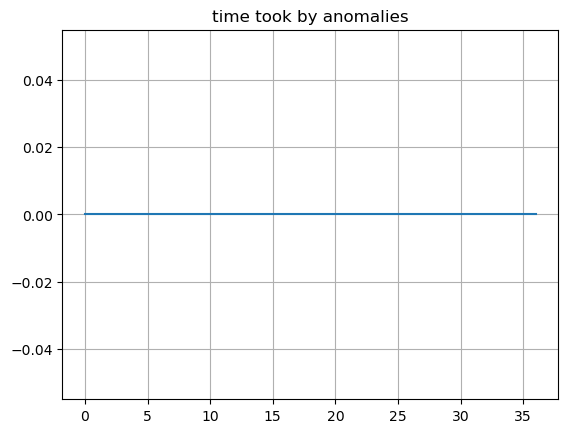

In [ ]:

sys.stdout = open(r".\outputs\anomaly_freq.txt","w")
anomaly_times = []
top_anomalies_by_leverage = [] # store tuple of (anom score, idx)
top_anomalies_by_proj = []
top_n_percent_leverage = []
top_n_percent_proj = []

for epoch,flow_start_idx in enumerate(range(0,data_length,hp["flow_size"])):
    print(f"------------ epoch {epoch+1} / {int(data_length/hp["flow_size"])+1} ------------", flush=True)
    flow_end_idx = flow_start_idx+hp["flow_size"]
    if(flow_end_idx>data_length): flow_end_idx=data_length
    print(f"loading rows {flow_start_idx} to {flow_end_idx}", flush=True)
    flow = data[flow_start_idx:flow_end_idx]
    if (epoch==0):
        sketch = np.zeros((hp["sketch_size"], num_features))

    # anomaly detectoin
    if(epoch!=0):  # because sketch is zero at 0 and every one will be anomaly then !
        
        start_time = time.time()
        leverage, proj_dist = compute_anomaly_scores(data=flow,sketch=sketch,k=hp["anomaly_top_singular"])
        end_time = time.time()
        print(f"anomaly score computations took {end_time - start_time:.4f} seconds", flush=True)
        anomaly_times.append(int(end_time - start_time))

        # leverage
        for idx , anom in enumerate(leverage):
            idx_main = idx+flow_start_idx
            if len(top_anomalies_by_leverage) < hp["anomaly_minheap_size"]:
                heapq.heappush(top_anomalies_by_leverage, (anom, idx_main))
            else:
                # only push if current score is higher than the smallest in heap
                if anom > top_anomalies_by_leverage[0][0]:
                    heapq.heapreplace(top_anomalies_by_leverage, (anom, idx_main))

        sorted_top = sorted(top_anomalies_by_leverage, key=lambda x: x[0], reverse=True) # sorted list of top keys by score descending (reverse=true)
        n_percent = int(hp["anomaly_top_percent"] * len(sorted_top))
        top_n_percent_leverage = sorted_top[:n_percent]

        # proj dist
        for idx , anom in enumerate(proj_dist):
            idx_main = idx+flow_start_idx
            if len(top_anomalies_by_proj) < hp["anomaly_minheap_size"]:
                heapq.heappush(top_anomalies_by_proj, (anom, idx_main))
            else:
                if anom > top_anomalies_by_proj[0][0]:
                    heapq.heapreplace(top_anomalies_by_proj, (anom, idx_main))
        
        sorted_top = sorted(top_anomalies_by_proj, key=lambda x: x[0], reverse=True) # sorted list of top keys by score descending (reverse=true)
        n_percent = int(hp["anomaly_top_percent"] * len(sorted_top))
        top_n_percent_proj = sorted_top[:n_percent]
        # print(f"top {hp["anomaly_top_percent"]} percent of top {hp["anomaly_minheap_size"]} anomalies (score, index):\n{top_n_percent_leverage}")

    # now we do freq dir sketch
    sketch = frequent_directions(hp["sketch_size"],flow,sketch)
    
plt.title("time took by anomalies")
plt.plot(anomaly_times)
plt.ylim(-0.2,0.2)
plt.grid(True)
plt.show()

In [52]:
all_data = range(0,data_length,1)
# not_anomaly = [x for x in all_data if x not in anomalies_gt]

# not anomaly anomaly is true 1
# anomaly_gt is true 1
# top_n_percent_leverage and the other one is predicted 1

y_true = [1 if x in anomalies_gt else 0 for x in all_data]

In [53]:
pred_indices = [idx for score, idx in top_n_percent_leverage]
y_pred = [1 if x in pred_indices else 0 for x in all_data]

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("leverage evaluation")
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

pred_indices = [idx for score, idx in top_n_percent_proj]
y_pred = [1 if x in pred_indices else 0 for x in all_data]

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("project distance evaluation")
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# method 2

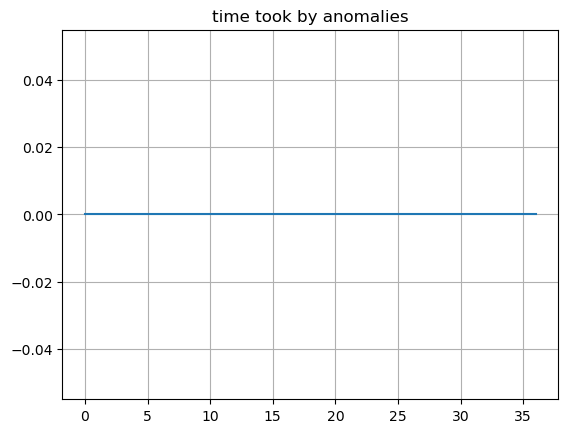

In [54]:
# std updated based on Welford’s online algorithm
n_lev = 0
mean_lev =0
M2_lev =0  # sum of squares of differences from the mean

n_proj = 0
mean_proj =0
M2_proj =0  

def update_stats(x, n, mean, M2):
    n += 1
    delta = x - mean
    mean += delta / n
    delta2 = x - mean
    M2 += delta * delta2
    return n, mean, M2

def current_std(n, M2):
    return math.sqrt(M2 / (n - 1)) if n > 1 else 0.0


sys.stdout = open(r".\outputs\anomaly_freq_method2.txt","w")
anomaly_times = []
top_anomalies_by_leverage = []
top_anomalies_by_proj = []

for epoch,flow_start_idx in enumerate(range(0,data_length,hp["flow_size"])):
    print(f"------------ epoch {epoch+1} / {int(data_length/hp["flow_size"])+1} ------------", flush=True)
    flow_end_idx = flow_start_idx+hp["flow_size"]
    if(flow_end_idx>data_length): flow_end_idx=data_length
    print(f"loading rows {flow_start_idx} to {flow_end_idx}", flush=True)
    flow = data[flow_start_idx:flow_end_idx]
    if (epoch==0):
        sketch = np.zeros((hp["sketch_size"], num_features))

    # anomaly detectoin
    if(epoch!=0):  # because sketch is zero at 0 and every one will be anomaly then !
        
        start_time = time.time()
        leverage, proj_dist = compute_anomaly_scores(data=flow,sketch=sketch,k=hp["anomaly_top_singular"])
        end_time = time.time()
        print(f"anomaly score computations took {end_time - start_time:.4f} seconds", flush=True)
        anomaly_times.append(int(end_time - start_time))

        # leverage
        for anom in leverage:
            n_lev, mean_lev, M2_lev = update_stats(anom, n_lev, mean_lev, M2_lev)
        std_lev = current_std(n_lev, M2_lev)
        threshold = mean_lev + 3 * std_lev

        for idx,anom in enumerate(leverage):
            idx_main = idx+flow_start_idx
            if anom >= threshold:
                top_anomalies_by_leverage.append((anom,idx_main))
        
        # remove alrady anomalies that no more anomalies ? we dont do this because there might be some concept drift
        # they could be anomalies that time

        # proj dist
        for anom in proj_dist:
            n_proj, mean_proj, M2_proj = update_stats(anom, n_proj, mean_proj, M2_proj)
        std_proj = current_std(n_proj, M2_proj)
        threshold = mean_proj + 3 * std_proj

        for idx,anom in enumerate(proj_dist):
            idx_main = idx+flow_start_idx
            if anom >= threshold:
                top_anomalies_by_proj.append((anom,idx_main))

    # now we do freq dir sketch
    sketch = frequent_directions(hp["sketch_size"],flow,sketch)
    
plt.title("time took by anomalies")
plt.plot(anomaly_times)
plt.grid(True)
plt.show()

In [55]:
pred_indices = [idx for score, idx in top_anomalies_by_leverage]
y_pred = [1 if x in pred_indices else 0 for x in all_data]

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("leverage evaluation")
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

pred_indices = [idx for score, idx in top_anomalies_by_proj]
y_pred = [1 if x in pred_indices else 0 for x in all_data]

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("project distance evaluation")
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

<h1>#########################################</h1>
here i dont use assos rule learning because cols are no more items<br>
i first do random gaussian projection to reduce num features (reconstruction rate , total variance and frob norm monitored)<br>
then i will do freq dir to reduce datapoints (total variance and frob norm monitored)<br>
at both anomaly detection will be done<br>
we calc num features based on Johnson-Lindenstrauss lemma on the first data flow and keep that same till end<br>
base on above result for simplicity only proj dist and method 2 anomaly detection applied

In [56]:
sys.stdout = open(r".\outputs\output_gaussian.txt","w")
reconstruction_errors=[]
frob_norms = []
tot_variances = []
gaussian_times = []
freqdir_times = []
anomaly_times = []
top_anomalies_by_proj=[]
n_proj = 0
mean_proj = 0
M2_proj = 0  

for epoch,flow_start_idx in enumerate(range(0,data_length,hp["flow_size"])):
    print(f"------------ epoch {epoch+1} / {int(data_length/hp["flow_size"])+1} ------------", flush=True)
    flow_end_idx = flow_start_idx+hp["flow_size"]
    if(flow_end_idx>data_length): flow_end_idx=data_length
    print(f"loading rows {flow_start_idx} to {flow_end_idx}", flush=True)
    flow = data[flow_start_idx:flow_end_idx]
    if (epoch==0):
        start_time = time.time()
        frob_norms.append(frobenius_norm(flow))
        tot_variances.append(total_variance(flow))
        k = calc_k_for_gaussian(data.shape[0],hp["gaussian_random_project_error"])
        print(f"k selected for dim reduction with error {hp["gaussian_random_project_error"]} is {k} out of {num_features}")
        sketch = np.zeros((hp["sketch_size"], k))
        end_time = time.time()
        print(f"processing first flow took {end_time - start_time:.4f} seconds", flush=True)

    # do gaussian random projectoin on the data
    start_time = time.time()
    projected,reconstruction_error = gaussian_random_projection(flow,k)
    end_time = time.time()
    gaussian_times.append(int(end_time - start_time))
    print(f"gaussian took {end_time - start_time:.4f} seconds", flush=True)
    reconstruction_errors.append(reconstruction_error)
    # frob_norms.append(frobenius_norm(projected))
    # tot_variances.append(total_variance(projected))

    if(epoch!=0):
        print(f"starting anomaly detection", flush=True)
        start_time = time.time()
        leverage, proj_dist = compute_anomaly_scores(data=projected,sketch=sketch,k=hp["anomaly_top_singular"])
        end_time = time.time()
        print(f"anomaly detection took {end_time - start_time:.4f} seconds", flush=True)
        anomaly_times.append(int(end_time - start_time))
        # proj dist
        for anom in proj_dist:
            n_proj, mean_proj, M2_proj = update_stats(anom, n_proj, mean_proj, M2_proj)
        std_proj = current_std(n_proj, M2_proj)
        threshold = mean_proj + 3 * std_proj

        for idx,anom in enumerate(proj_dist):
            idx_main = idx+flow_start_idx
            if anom >= threshold:
                top_anomalies_by_proj.append((anom,idx_main))
        
    
    print("updating sketch")
    start_time = time.time()
    sketch = frequent_directions(hp["sketch_size"],projected,sketch)
    end_time = time.time()
    print(f"frequent directions took {end_time - start_time:.4f} seconds", flush=True)
    freqdir_times.append(int(end_time - start_time))
    # calc frob norm
    frob_norms.append(frobenius_norm(sketch))
    tot_variances.append(total_variance(sketch))

    ################################################################################



        

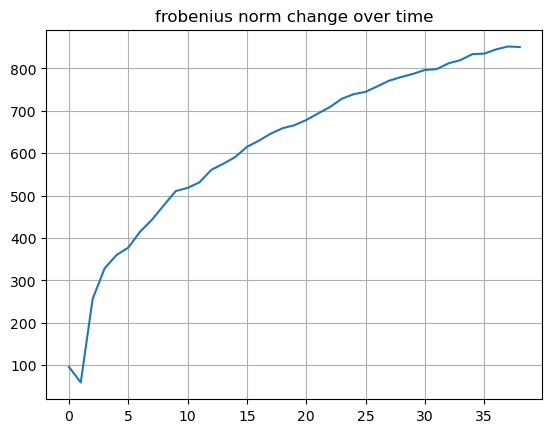

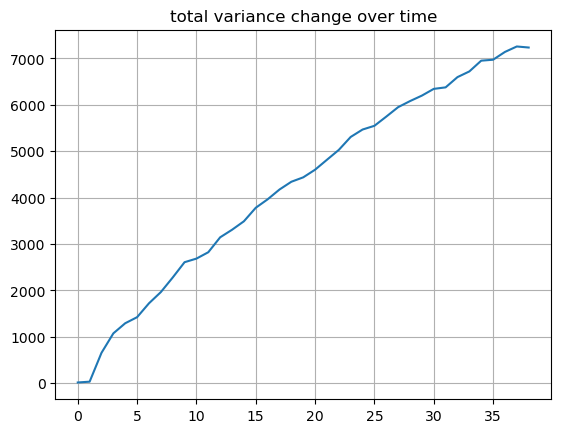

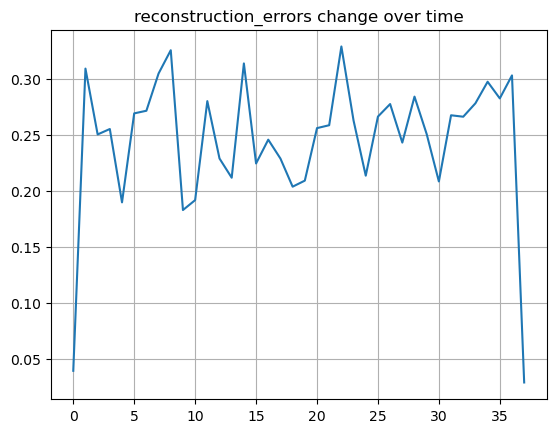

In [57]:
#print("note that first norm is for the first flow")
plt.title("frobenius norm change over time")
plt.plot(frob_norms)
plt.grid(True)
plt.show()

#print("note that first is for the first flow")
plt.title("total variance change over time")
plt.plot(tot_variances)
plt.grid(True)
plt.show()

plt.title("reconstruction_errors change over time")
plt.plot(reconstruction_errors)
plt.grid(True)
plt.show()


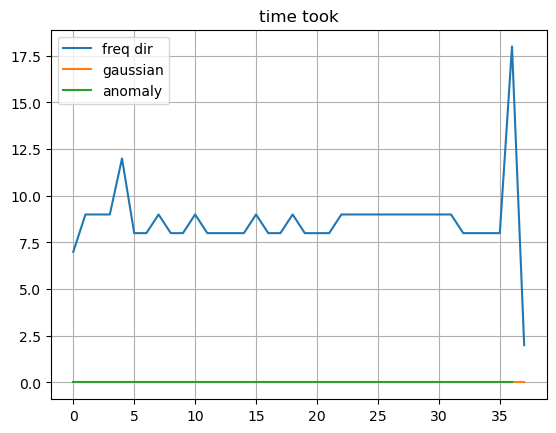

In [58]:
plt.title("time took")
plt.plot(freqdir_times,label="freq dir")
plt.plot(gaussian_times,label="gaussian")
plt.plot(anomaly_times,label="anomaly")
plt.legend()
plt.grid(True)
plt.show()

In [59]:
pred_indices = [idx for score, idx in top_anomalies_by_proj]
y_pred = [1 if x in pred_indices else 0 for x in all_data]

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("project distance evaluation")
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

<h1>########################################</h1>
incremental pca

In [84]:
from tqdm import tqdm

sys.stdout = open(r".\outputs\output_ipca.txt","w")
reconstruction_errors=[]
explained_var = []
frob_norms = []
tot_variances = []
ipca_times = []
freqdir_times = []
anomaly_times = []
top_anomalies_by_proj=[]
n_proj = 0
mean_proj = 0
M2_proj = 0  

ipca = IPCA(n_components=hp["ipca_ncomponent"])

for epoch,flow_start_idx in enumerate(range(0,data_length,hp["flow_size"])):
    print(f"------------ epoch {epoch+1} / {int(data_length/hp["flow_size"])+1} ------------", flush=True)
    flow_end_idx = flow_start_idx+hp["flow_size"]
    if(flow_end_idx>data_length): flow_end_idx=data_length
    print(f"loading rows {flow_start_idx} to {flow_end_idx}", flush=True)
    flow = data[flow_start_idx:flow_end_idx]
    if (epoch==0):
        start_time = time.time()
        frob_norms.append(frobenius_norm(flow))
        tot_variances.append(total_variance(flow))
        print(f"we use {hp["ipca_ncomponent"]} for ipca")
        sketch = np.zeros((hp["sketch_size"], hp["ipca_ncomponent"]))
        end_time = time.time()
        print(f"processing first flow took {end_time - start_time:.4f} seconds", flush=True)

    # do ipca on the data
    start_time = time.time()
    projected = np.zeros((flow.shape[0],hp["ipca_ncomponent"]))
    for idx,row in enumerate(tqdm(flow)):
        projected_row,reconstruction_error,var_ratio = ipca.step(row.astype(np.float64))
        projected[idx]=projected_row
        reconstruction_errors.append(reconstruction_error)
        explained_var.append(var_ratio)
    end_time = time.time()
    ipca_times.append(int(end_time - start_time))
    print(f"ipca took {end_time - start_time:.4f} seconds", flush=True)

    if(epoch!=0):
        print(f"starting anomaly detection", flush=True)
        start_time = time.time()
        leverage, proj_dist = compute_anomaly_scores(data=projected,sketch=sketch,k=hp["anomaly_top_singular"])
        end_time = time.time()
        print(f"anomaly detection took {end_time - start_time:.4f} seconds", flush=True)
        anomaly_times.append(int(end_time - start_time))
        # proj dist
        for anom in proj_dist:
            n_proj, mean_proj, M2_proj = update_stats(anom, n_proj, mean_proj, M2_proj)
        std_proj = current_std(n_proj, M2_proj)
        threshold = mean_proj + 3 * std_proj

        for idx,anom in enumerate(proj_dist):
            idx_main = idx+flow_start_idx
            if anom >= threshold:
                top_anomalies_by_proj.append((anom,idx_main))
        
    
    print("updating sketch")
    start_time = time.time()
    sketch = frequent_directions(hp["sketch_size"],projected,sketch)
    end_time = time.time()
    print(f"frequent directions took {end_time - start_time:.4f} seconds", flush=True)
    freqdir_times.append(int(end_time - start_time))
    # calc frob norm
    frob_norms.append(frobenius_norm(sketch))
    tot_variances.append(total_variance(sketch))

    ################################################################################



        

100%|██████████| 36/36 [00:07<00:00,  5.10it/s]


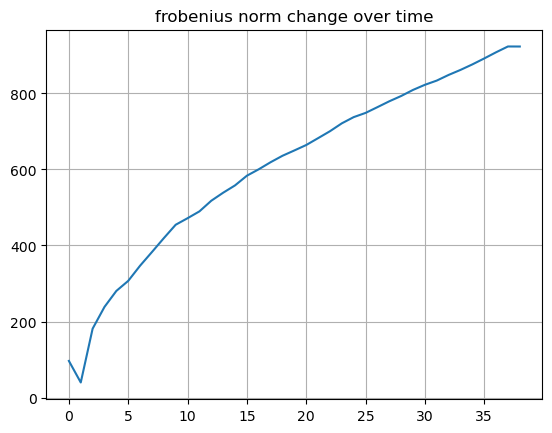

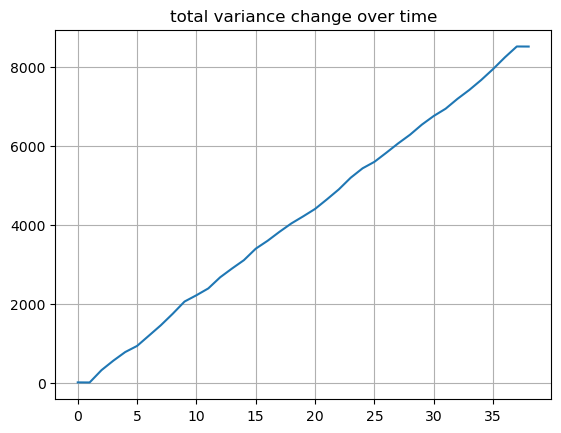

In [89]:
#print("note that first norm is for the first flow")
plt.title("frobenius norm change over time")
plt.plot(frob_norms)
plt.grid(True)
plt.show()

#print("note that first is for the first flow")
plt.title("total variance change over time")
plt.plot(tot_variances)
plt.grid(True)
plt.show()

In [138]:
print(explained_var[100][hp["ipca_ncomponent"]-1])

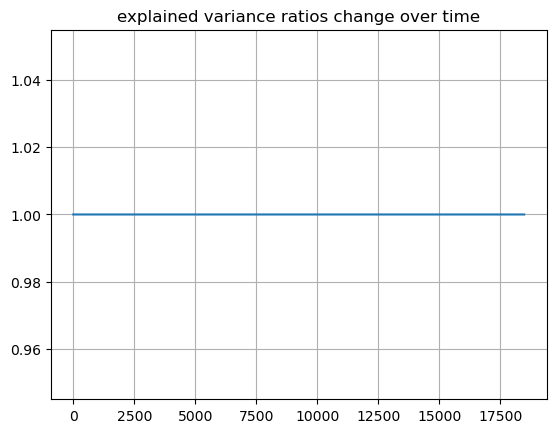

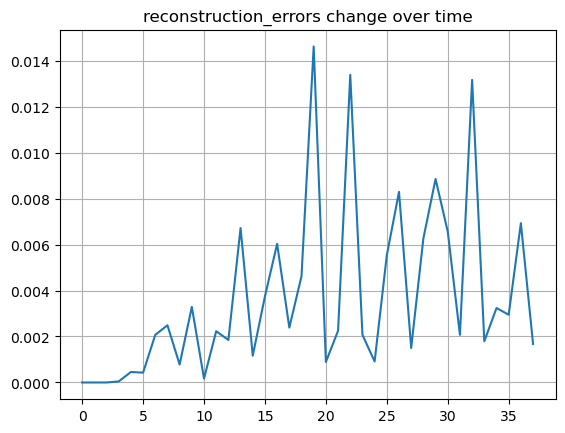

In [145]:
plt.title("explained variance ratios change over time")
# plt.plot(explained_var[hp["ipca_ncomponent"]-1])
last_col = []
for row in explained_var:
    if(row[hp["ipca_ncomponent"]-1] >=0):
        last_col.append(round(row[hp["ipca_ncomponent"]-1],2))
print(last_col)
print(min(last_col), max(last_col))

# ax = plt.gca()
# ax.ticklabel_format(style='plain', useOffset=False, axis='y')

plt.plot(last_col)
plt.grid(True)
plt.show()

plt.title("reconstruction_errors change over time")
plt.plot(reconstruction_errors[::500])
plt.grid(True)
plt.show()


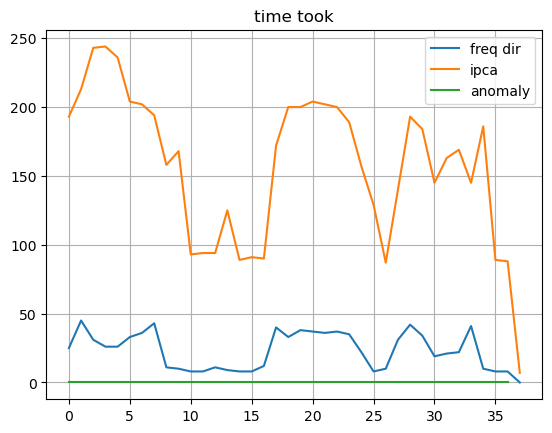

In [87]:
plt.title("time took")
plt.plot(freqdir_times,label="freq dir")
plt.plot(ipca_times,label="ipca")
plt.plot(anomaly_times,label="anomaly")
plt.legend()
plt.grid(True)
plt.show()

In [88]:
pred_indices = [idx for score, idx in top_anomalies_by_proj]
y_pred = [1 if x in pred_indices else 0 for x in all_data]

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("project distance evaluation")
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")